      tconst                    englishTitle                   originalTitle  \
0  tt0000009                      Miss Jerry                      Miss Jerry   
1  tt0000147   The Corbett-Fitzsimmons Fight   The Corbett-Fitzsimmons Fight   
2  tt0000574     The Story of the Kelly Gang     The Story of the Kelly Gang   
3  tt0000591                The Prodigal Son               L'enfant prodigue   
4  tt0000679  The Fairylogue and Radio-Plays  The Fairylogue and Radio-Plays   

   year  runtimeMinutes                      genres  rating  numVotes  
0  1894              45                     Romance     5.4       212  
1  1897             100      Documentary,News,Sport     5.2       516  
2  1906              70  Action,Adventure,Biography     6.0       907  
3  1907              90                       Drama     5.4        24  
4  1908             120           Adventure,Fantasy     5.3        74  
tconst            0
englishTitle      0
originalTitle     0
year              0
runtime

C:\Users\Dille\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dille\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Dille\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

      Action       0.38      0.15      0.21      2992
       Adult       0.57      0.13      0.22       245
   Adventure       0.39      0.04      0.07      1931
   Animation       0.00      0.00      0.00        62
   Biography       0.42      0.02      0.03       549
      Comedy       0.41      0.53      0.46      8387
       Crime       0.35      0.08      0.13      2476
 Documentary       0.48      0.11      0.17       544
       Drama       0.42      0.68      0.52      9740
      Family       0.00      0.00      0.00       135
     Fantasy       0.00      0.00      0.00       111
   Film-Noir       0.00      0.00      0.00        19
     History       0.00      0.00      0.00        24
      Horror       0.44      0.29      0.35       796
       Music       0.00      0.00      0.00        39
     Musical       0.00      0.00      0.00       224
     Mystery       0.40      0.01      0.02       166
     Romance       0.00    

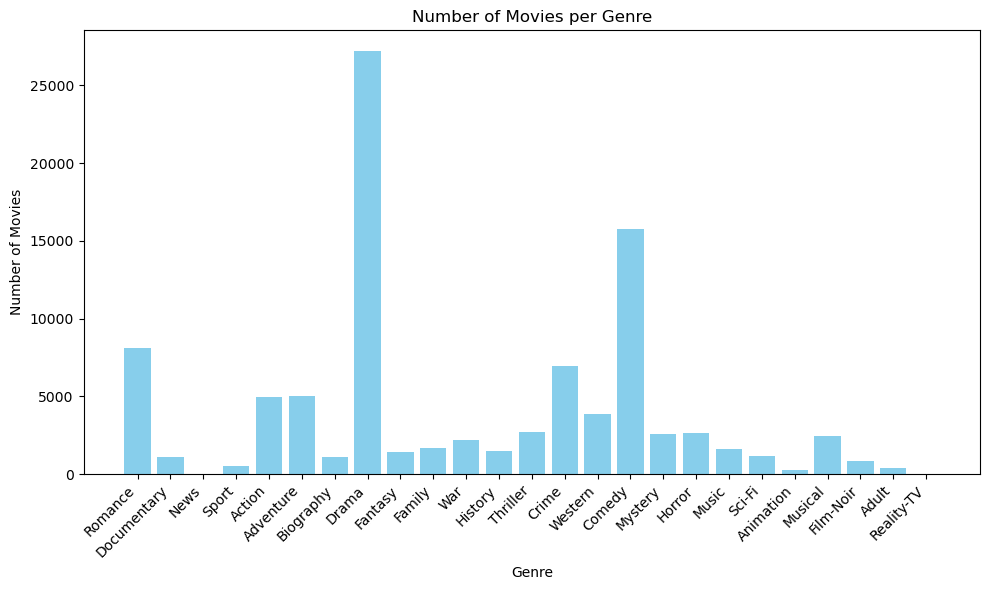

In [1]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from scipy.sparse import hstack, csr_matrix
import matplotlib.pyplot as plt

# Load a smaller subset of the dataset to manage memory efficiently
file_path = 'IMDB.tsv'  # File name
chunk_size = 50000  # Process in smaller chunks
df_list = []

# Use a loop to read the file in chunks and keep a smaller subset
for chunk in pd.read_csv(file_path, delimiter='\t', chunksize=chunk_size):
    df_list.append(chunk)
    if len(df_list) >= 1:  # Limit the number of chunks to process
        break

df = pd.concat(df_list, axis=0)

# Display the first few rows of the dataset
print(df.head())

# Check for missing values
print(df.isnull().sum())

# Fill missing values if necessary
df = df.fillna('')

# Convert genres to a list of genres for each movie
df['genres'] = df['genres'].str.split(',')

# Use only the first genre for each movie (or choose randomly)
df['primary_genre'] = df['genres'].apply(lambda x: x[0])

# Vectorize the text features (englishTitle and originalTitle)
vectorizer = TfidfVectorizer(max_features=300)  # Further reduce the number of features
X_title_sparse = vectorizer.fit_transform(df['englishTitle'] + ' ' + df['originalTitle'])

# Extract other features and convert them to sparse format
scaler = StandardScaler()
X_runtime_sparse = csr_matrix(scaler.fit_transform(df['runtimeMinutes'].values.reshape(-1, 1)))
X_rating_sparse = csr_matrix(scaler.fit_transform(df['rating'].values.reshape(-1, 1)))
X_votes_sparse = csr_matrix(scaler.fit_transform(df['numVotes'].values.reshape(-1, 1)))
X_year_sparse = csr_matrix(scaler.fit_transform(df['year'].values.reshape(-1, 1)))

# Combine all features into a single sparse matrix
X_sparse = hstack((X_title_sparse, X_runtime_sparse, X_rating_sparse, X_votes_sparse, X_year_sparse))

# Target variable
y = df['primary_genre']

# Split the dataset into training and testing sets with a larger test size
X_train, X_test, y_train, y_test = train_test_split(X_sparse, y, test_size=0.6, random_state=42)

# Hyperparameter tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Train a Random Forest classifier using Grid Search for hyperparameter tuning
rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best estimator
best_rf = grid_search.best_estimator_

# Predict genres on the test set
y_pred = best_rf.predict(X_test)

# Evaluate the model
print(classification_report(y_test, y_pred))
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

# Example new movie data
new_movie = {
    'englishTitle': 'New Movie Title',
    'originalTitle': 'Original Movie Title',
    'runtimeMinutes': 120,
    'rating': 7.5,
    'numVotes': 1500,
    'year': 2024
}

# Vectorize and standardize the new movie data
X_new_title_sparse = vectorizer.transform([new_movie['englishTitle'] + ' ' + new_movie['originalTitle']])
X_new_runtime_sparse = csr_matrix(scaler.transform([[new_movie['runtimeMinutes']]]))
X_new_rating_sparse = csr_matrix(scaler.transform([[new_movie['rating']]]))
X_new_votes_sparse = csr_matrix(scaler.transform([[new_movie['numVotes']]]))
X_new_year_sparse = csr_matrix(scaler.transform([[new_movie['year']]]))

# Combine all features into a single sparse matrix
X_new_sparse = hstack((X_new_title_sparse, X_new_runtime_sparse, X_new_rating_sparse, X_new_votes_sparse, X_new_year_sparse))

# Predict the genre
predicted_genre = best_rf.predict(X_new_sparse)
print(f'Predicted Genre: {predicted_genre[0]}')
all_genres = df['genres'].explode()

# Use Counter to count occurrences of each genre
from collections import Counter
genre_counter = Counter(all_genres)

# Extract genres and their counts
genres = list(genre_counter.keys())
counts = list(genre_counter.values())

# Create a bar graph
plt.figure(figsize=(10, 6))
plt.bar(genres, counts, color='skyblue')

# Add titles and labels
plt.title('Number of Movies per Genre')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')

# Show the bar graph
plt.tight_layout()
plt.show()
